In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_74633/680206115.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = 'Shanghai/'

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [7]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

Shanghai/part_A_final/train_data/images/IMG_132.jpg
(800, 600)
generate density...


/tmp/ipykernel_74633/4051122479.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
Shanghai/part_A_final/train_data/images/IMG_145.jpg
(561, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_187.jpg
(387, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_177.jpg
(768, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_59.jpg
(686, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_9.jpg
(536, 800)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_11.jpg
(686, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_252.jpg
(400, 600)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_210.jpg
(768, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_221.jpg
(679, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_167.jpg
(830, 1024)
generate density...
done.
Shanghai/part_A_final/train_data/images/IMG_125.jpg
(565, 849)
generate density...
done.
Shanghai/pa

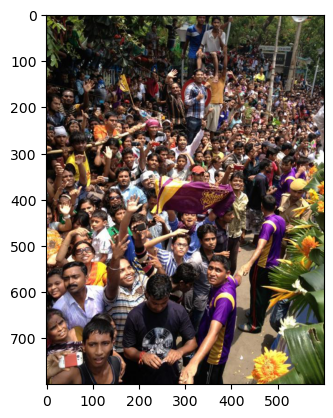

In [8]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

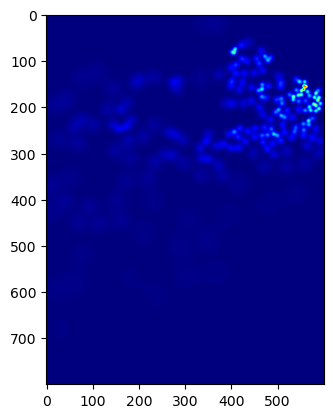

In [9]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [10]:
np.sum(groundtruth)# don't mind this slight variation

198.50275

In [11]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [12]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [13]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

Shanghai/part_B_final/train_data/images/IMG_309.jpg
Shanghai/part_B_final/train_data/images/IMG_379.jpg
Shanghai/part_B_final/train_data/images/IMG_132.jpg
Shanghai/part_B_final/train_data/images/IMG_145.jpg
Shanghai/part_B_final/train_data/images/IMG_187.jpg
Shanghai/part_B_final/train_data/images/IMG_357.jpg
Shanghai/part_B_final/train_data/images/IMG_177.jpg
Shanghai/part_B_final/train_data/images/IMG_346.jpg
Shanghai/part_B_final/train_data/images/IMG_59.jpg
Shanghai/part_B_final/train_data/images/IMG_9.jpg
Shanghai/part_B_final/train_data/images/IMG_11.jpg
Shanghai/part_B_final/train_data/images/IMG_252.jpg
Shanghai/part_B_final/train_data/images/IMG_210.jpg
Shanghai/part_B_final/train_data/images/IMG_221.jpg
Shanghai/part_B_final/train_data/images/IMG_167.jpg
Shanghai/part_B_final/train_data/images/IMG_125.jpg
Shanghai/part_B_final/train_data/images/IMG_200.jpg
Shanghai/part_B_final/train_data/images/IMG_269.jpg
Shanghai/part_B_final/train_data/images/IMG_28.jpg
Shanghai/part_B_f